In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rt-iot-resampled/resampled_dataset.csv
/kaggle/input/rt-iot2022/RT_IOT2022.csv


Epoch 10/40
Distillation loss: 0.7327
DQN loss: 0.0946
SSL loss: 0.1313
Total loss: 0.8924
---
Epoch 20/40
Distillation loss: 0.2456
DQN loss: 0.4199
SSL loss: 0.0715
Total loss: 0.4431
---
Epoch 30/40
Distillation loss: 0.2258
DQN loss: 0.6119
SSL loss: 0.0663
Total loss: 0.4757
---
Epoch 40/40
Distillation loss: 0.2193
DQN loss: 3.8379
SSL loss: 0.0601
Total loss: 1.4308
---
Accuracy: 0.9284, Precision: 0.9286, Recall: 0.9284, F1-score: 0.9266


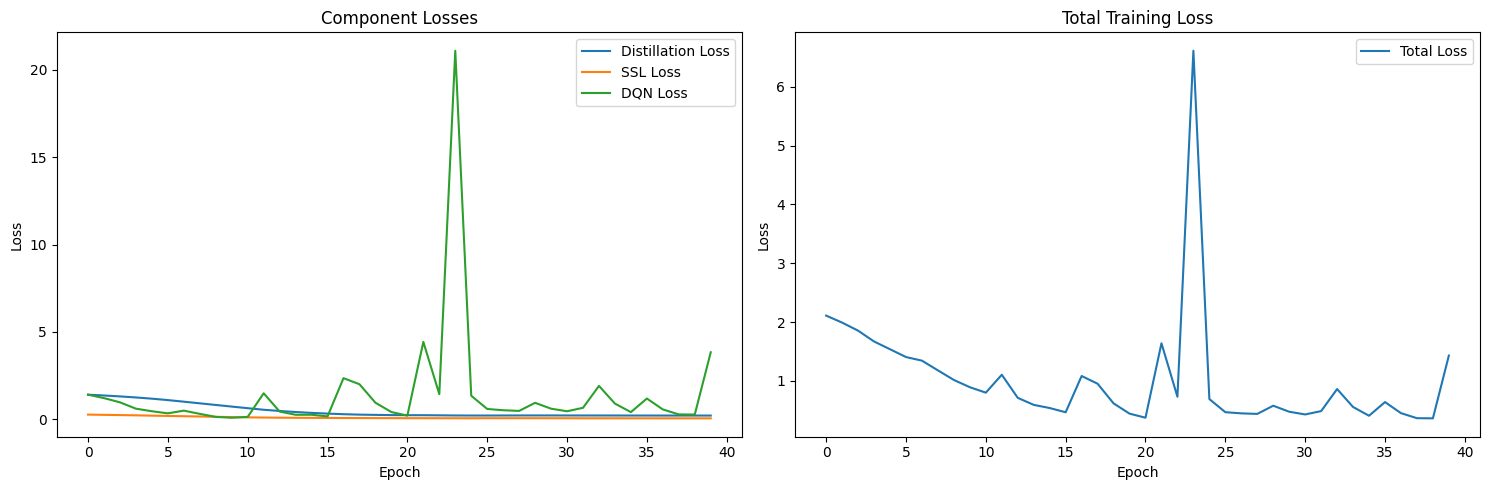

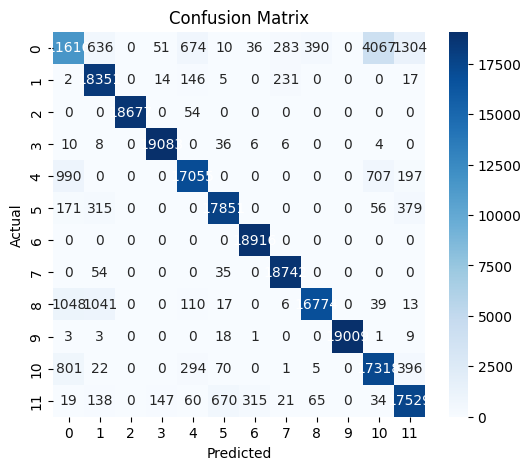

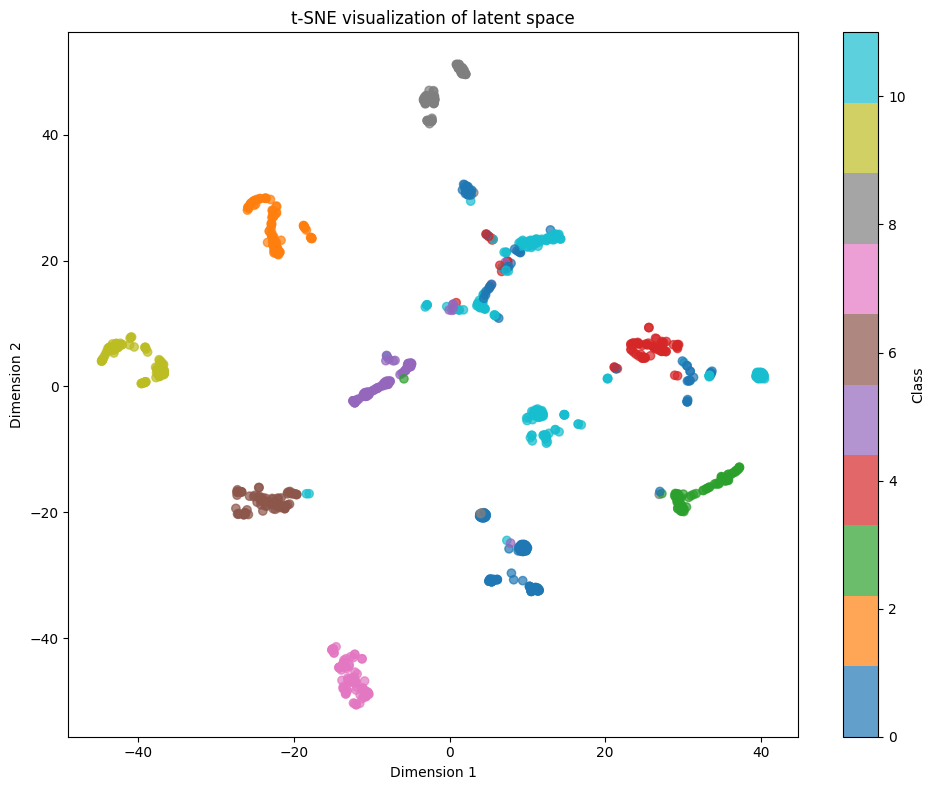

Enhanced model saved as enhanced_student_ssl_dqn_model.pkl
Average inference time per batch: 623.66 ms
Average inference time per sample: 0.00 ms


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import pickle
from collections import deque
import random

# Load dataset
data = pd.read_csv('/kaggle/input/rt-iot2022/RT_IOT2022.csv')

label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

X = data.drop(columns=['Attack_type'])
y = data['Attack_type']

# Encode categorical labels
y = LabelEncoder().fit_transform(y)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define Teacher Model
class TeacherModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TeacherModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Define Enhanced Student Model with Self-Supervised Learning and DQN capabilities
class EnhancedStudentModel(nn.Module):
    def __init__(self, input_dim, num_classes, latent_dim=64):
        super(EnhancedStudentModel, self).__init__()
        # Encoder - shared across all tasks
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        )
        
        # Classification head
        self.classifier = nn.Linear(latent_dim, num_classes)
        
        # Q-value head (for DQN functionality)
        self.q_values = nn.Linear(latent_dim, num_classes)
        
        # Self-supervised learning heads
        # 1. Reconstruction decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
        # 2. Feature prediction head (predicts masked features)
        self.feature_predictor = nn.Linear(latent_dim, input_dim)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Get latent representation
        features = self.encoder(x)
        features_with_dropout = self.dropout(features)
        
        # Return outputs for all tasks
        return {
            'classification': self.classifier(features_with_dropout),
            'q_values': self.q_values(features_with_dropout),
            'reconstruction': self.decoder(features),
            'feature_prediction': self.feature_predictor(features)
        }
    
    def get_q_values(self, x):
        features = self.encoder(x)
        return self.q_values(features)
    
    def get_classification(self, x):
        features = self.encoder(x)
        return self.classifier(features)
    
    def get_latent_features(self, x):
        return self.encoder(x)

# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, min(len(self.buffer), batch_size))
        states, actions, rewards, next_states, dones = zip(*batch)
        return (torch.stack(states), 
                torch.tensor(actions), 
                torch.tensor(rewards, dtype=torch.float32), 
                torch.stack(next_states), 
                torch.tensor(dones, dtype=torch.float32))
    
    def __len__(self):
        return len(self.buffer)

# Helper functions for self-supervised learning
def create_masked_inputs(x, mask_ratio=0.15):
    """Create masked versions of inputs for self-supervised learning"""
    batch_size, feat_dim = x.shape
    
    # Create a mask tensor (1 = keep, 0 = mask)
    mask = torch.ones_like(x)
    mask_indices = torch.bernoulli(torch.ones_like(x) * mask_ratio).bool()
    mask[mask_indices] = 0
    
    # Create masked input (replace masked values with zeros)
    masked_x = x * mask
    
    return masked_x, mask, x

# Training configurations
input_dim = X_train.shape[1]
num_classes = len(set(y))  # Dynamically determine number of classes
teacher = TeacherModel(input_dim, num_classes)
enhanced_student = EnhancedStudentModel(input_dim, num_classes)

criterion = nn.CrossEntropyLoss()
reconstruction_criterion = nn.MSELoss()
distillation_criterion = nn.KLDivLoss(reduction='batchmean')
optimizer_teacher = optim.Adam(teacher.parameters(), lr=0.001)
optimizer_student = optim.Adam(enhanced_student.parameters(), lr=0.001)

def train_teacher(model, optimizer, criterion, X_train, y_train, epochs=50):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

train_teacher(teacher, optimizer_teacher, criterion, X_train_tensor, y_train_tensor)

# Modified Knowledge Distillation with DQN and Self-Supervised Learning integration
alpha = 0.5        # Weight for distillation loss
temperature = 3.0  # Temperature for distillation
beta = 0.3         # Weight for Q-learning loss
lambda_recon = 0.2 # Weight for reconstruction loss
lambda_feat = 0.2  # Weight for feature prediction loss

# Create a replay buffer
replay_buffer = ReplayBuffer(capacity=10000)

# Function to create synthetic DQN training data from classification dataset
def generate_dqn_samples(X, y, num_samples=1000):
    buffer = ReplayBuffer()
    indices = np.random.choice(len(X), num_samples, replace=True)
    
    for i in indices:
        state = X[i]
        action = y[i]
        
        # Create a synthetic next state with small random perturbation
        next_state = state + torch.randn_like(state) * 0.01
        
        # Reward is 1 for correct action (this is simplified)
        reward = 1.0
        
        # Termination signal (simplified)
        done = 0.0
        
        buffer.add(state, action, reward, next_state, done)
    
    return buffer

# Pre-fill replay buffer with synthetic samples
replay_buffer = generate_dqn_samples(X_train_tensor, y_train_tensor)

def train_enhanced_student(teacher, student, optimizer, X_train, y_train, replay_buffer, 
                           epochs=40, gamma=0.99, batch_size=64, scheduler=None):
    teacher.eval()
    student.train()
    
    # Initialize target network (for stable DQN learning)
    target_network = EnhancedStudentModel(input_dim, num_classes)
    target_network.load_state_dict(student.state_dict())
    target_network.eval()
    
    history = {
        'distill_loss': [],
        'dqn_loss': [],
        'ssl_loss': [],
        'total_loss': []
    }
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Step 1: Create masked inputs for self-supervised learning
        masked_inputs, mask, original_inputs = create_masked_inputs(X_train_tensor)
        
        # Step 2: Forward pass with both original and masked inputs
        outputs = student(X_train_tensor)
        masked_outputs = student(masked_inputs)
        
        # Get teacher outputs for distillation
        teacher_outputs = teacher(X_train_tensor).detach()
        
        # Classification loss with distillation
        distill_loss = (alpha * distillation_criterion(
            F.log_softmax(outputs['classification']/temperature, dim=1), 
            F.softmax(teacher_outputs/temperature, dim=1)
        )) + ((1 - alpha) * criterion(outputs['classification'], y_train))
        
        # Self-supervised learning losses
        # 1. Reconstruction loss
        recon_loss = reconstruction_criterion(outputs['reconstruction'], X_train_tensor)
        
        # 2. Feature prediction loss (predict original features from masked input)
        feature_pred_loss = reconstruction_criterion(
            masked_outputs['feature_prediction'] * (1 - mask),  # Only compute loss on masked positions
            original_inputs * (1 - mask)
        )
        
        # Combined SSL loss
        ssl_loss = lambda_recon * recon_loss + lambda_feat * feature_pred_loss
        
        # DQN loss
        dqn_loss = torch.tensor(0.0)
        if len(replay_buffer) >= batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
            
            # Current Q-values
            current_q = student.get_q_values(states)
            current_q_values = current_q.gather(1, actions.unsqueeze(1)).squeeze(1)
            
            # Target Q-values
            with torch.no_grad():
                next_q = target_network.get_q_values(next_states)
                max_next_q = next_q.max(1)[0]
                target_q_values = rewards + gamma * max_next_q * (1 - dones)
            
            # Compute Q-learning loss
            dqn_loss = F.mse_loss(current_q_values, target_q_values)
        
        # Combined loss
        total_loss = distill_loss + beta * dqn_loss + ssl_loss
        total_loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        # Periodically update target network
        if epoch % 5 == 0:
            target_network.load_state_dict(student.state_dict())
            
        # Generate new synthetic DQN samples occasionally
        if epoch % 10 == 0:
            new_samples = generate_dqn_samples(X_train_tensor, y_train_tensor, num_samples=200)
            for s, a, r, ns, d in zip(*new_samples.sample(200)):
                replay_buffer.add(s, a, r, ns, d)
        
        # Record losses
        history['distill_loss'].append(distill_loss.item())
        history['dqn_loss'].append(dqn_loss.item() if isinstance(dqn_loss, torch.Tensor) else dqn_loss)
        history['ssl_loss'].append(ssl_loss.item())
        history['total_loss'].append(total_loss.item())
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
            print(f"Distillation loss: {distill_loss.item():.4f}")
            print(f"DQN loss: {dqn_loss.item() if isinstance(dqn_loss, torch.Tensor) else dqn_loss:.4f}")
            print(f"SSL loss: {ssl_loss.item():.4f}")
            print(f"Total loss: {total_loss.item():.4f}")
            print("---")
    
    return history

# Create learning rate scheduler for better convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer_student, 
    max_lr=0.01,
    steps_per_epoch=1, 
    epochs=40,
    pct_start=0.3,
    div_factor=10.0
)

# Train the enhanced student model
history = train_enhanced_student(
    teacher, 
    enhanced_student, 
    optimizer_student, 
    X_train_tensor, 
    y_train_tensor, 
    replay_buffer,
    epochs=40,
    scheduler=scheduler
)

# Evaluation function
def evaluate(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        class_outputs = outputs['classification'] if isinstance(outputs, dict) else outputs
        _, predictions = torch.max(class_outputs, 1)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    cm = confusion_matrix(y_test, predictions)
    return accuracy, precision, recall, f1, cm, predictions

# Evaluate the model
accuracy, precision, recall, f1, cm, predictions = evaluate(enhanced_student, X_test_tensor, y_test_tensor)
print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['distill_loss'], label='Distillation Loss')
plt.plot(history['ssl_loss'], label='SSL Loss')
plt.plot(history['dqn_loss'], label='DQN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Component Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['total_loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Training Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature visualization using t-SNE (optional)
from sklearn.manifold import TSNE

def visualize_embeddings(model, X, y, n_samples=1000):
    """Visualize the learned embeddings using t-SNE"""
    if len(X) > n_samples:
        # Randomly sample data points
        indices = np.random.choice(len(X), n_samples, replace=False)
        X_sample = X[indices]
        y_sample = y[indices]
    else:
        X_sample = X
        y_sample = y
    
    # Extract latent features
    model.eval()
    with torch.no_grad():
        latent_features = model.get_latent_features(X_sample).cpu().numpy()
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(latent_features)
    
    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_sample.cpu().numpy(), 
                          cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Class')
    plt.title('t-SNE visualization of latent space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.tight_layout()
    plt.show()

# Visualize embeddings (choose a subset of test data)
visualize_embeddings(enhanced_student, X_test_tensor, y_test_tensor)

# Save the trained enhanced student model
model_filename = "enhanced_student_ssl_dqn_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(enhanced_student, file)

print(f"Enhanced model saved as {model_filename}")

# Benchmark model inference speed
def benchmark_inference_speed(model, X_test, num_runs=100):
    """Benchmark the model's inference speed"""
    model.eval()
    
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(X_test)
    end_time = time.time()
    
    avg_time_per_batch = (end_time - start_time) / num_runs
    avg_time_per_sample = avg_time_per_batch / len(X_test)
    
    return avg_time_per_batch, avg_time_per_sample

import time

# Benchmark the enhanced model
batch_time, sample_time = benchmark_inference_speed(enhanced_student, X_test_tensor)
print(f"Average inference time per batch: {batch_time*1000:.2f} ms")
print(f"Average inference time per sample: {sample_time*1000:.2f} ms")